In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load data as dataframe with Pandas
df_train = pd.read_csv("test_data_scientist/train.csv")
df_test = pd.read_csv("test_data_scientist/test.csv")
df_bu_feat = pd.read_csv("test_data_scientist/bu_feat.csv")

In [3]:
#convert "day_id" columns into a datetime column 
df_train["day_id"] = pd.to_datetime(df_train["day_id"], format="%Y-%m-%d")
df_test["day_id"] = pd.to_datetime(df_test["day_id"], format="%Y-%m-%d")

In [4]:
df_test["day_id"].min(),df_test["day_id"].max()

(Timestamp('2017-10-07 00:00:00'), Timestamp('2017-11-25 00:00:00'))

In [5]:
df_train.shape

(277719, 4)

In [6]:
df_train = df_train.drop_duplicates()

In [7]:
len(list(df_train["but_num_business_unit"].unique())),len(list(df_train["dpt_num_department"].unique()))

(322, 4)

In [8]:
list(df_train["dpt_num_department"].unique())

[127, 88, 73, 117]

In [9]:
# To forecast the turnover at store-department level, to be as much precise as possible, a model should be built for each
# business_unit-department, meaning 322*4=1288 models.
# It is too much. We need to find some ways to reduce this number.

<AxesSubplot:xlabel='day_id', ylabel='turnover'>

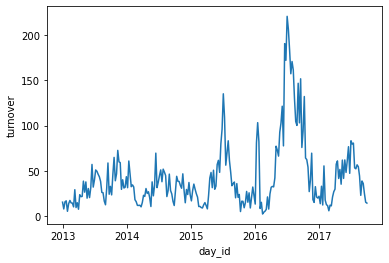

In [10]:
department = 73
business_unit = 1
df_train_viz = df_train.groupby(["day_id","dpt_num_department","but_num_business_unit"]).sum().reset_index()
filt = df_train_viz[(df_train_viz["dpt_num_department"]==department) & (df_train_viz["but_num_business_unit"]==business_unit)]
sns.lineplot(data=filt, x='day_id', y='turnover',palette="tab10")

In [11]:
df_train["year"] = df_train["day_id"].dt.year
df_train["month"] = df_train["day_id"].map(lambda x: x.strftime('%m'))
df_train["week"] = df_train["day_id"].map(lambda x: x.strftime('%W'))

In [12]:
df_train_grouped = df_train.groupby(["dpt_num_department","but_num_business_unit","year","month","week"]).sum().reset_index()
df_train_grouped = df_train_grouped[["turnover","dpt_num_department","but_num_business_unit","year","month","week"]]

In [13]:
df_train_grouped = df_train_grouped[df_train_grouped["turnover"]>=0]

In [14]:
df_train_grouped.head(2)

,turnover,dpt_num_department,but_num_business_unit,year,month,week
0,15.552508,73,1,2012,12,52
1,8.092452,73,1,2013,01,00


In [15]:
df_plot = df_train_grouped
df_plot["date"] = df_plot["year"].map(str) + df_plot["month"].map(str) + df_plot["week"].map(str)
df_plot["date"] = df_plot["date"].astype(int)

In [16]:
df_plot.head(2)

,turnover,dpt_num_department,but_num_business_unit,year,month,week,date
0,15.552508,73,1,2012,12,52,20121252
1,8.092452,73,1,2013,01,00,20130100


/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


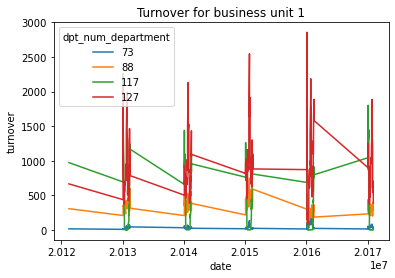

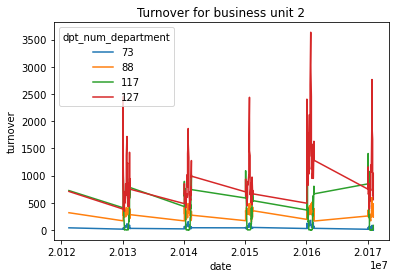

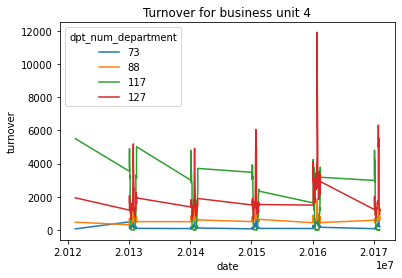

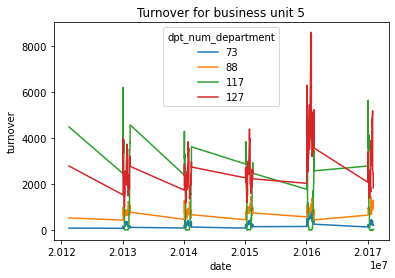

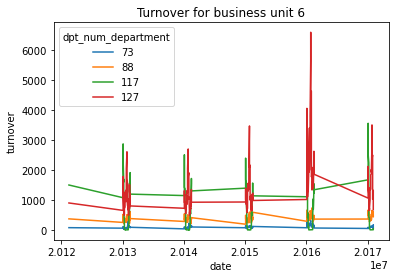

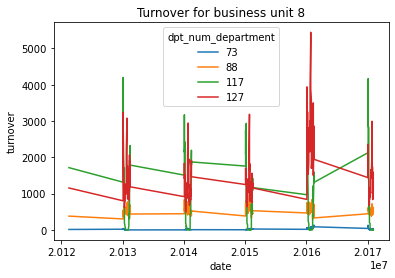

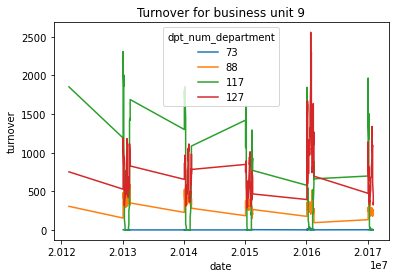

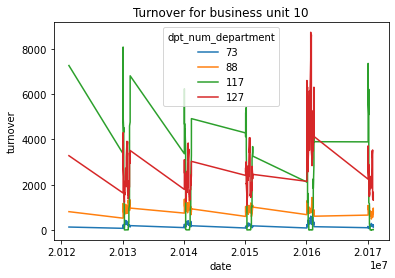

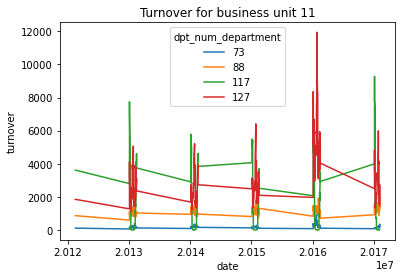

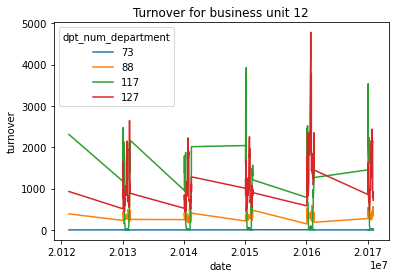

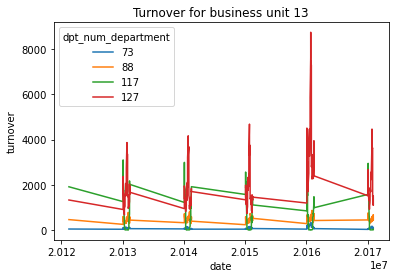

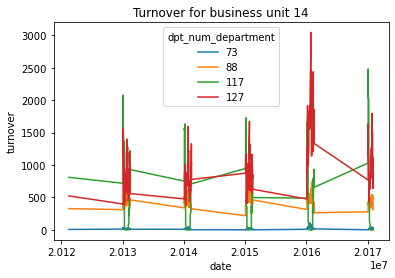

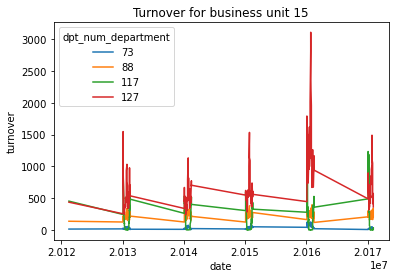

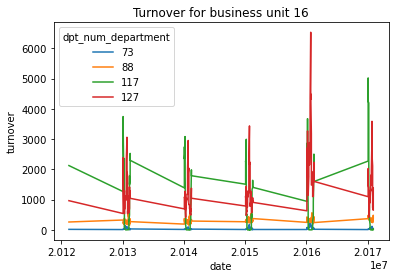

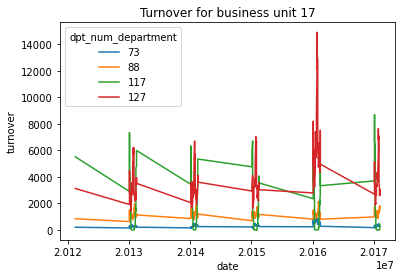

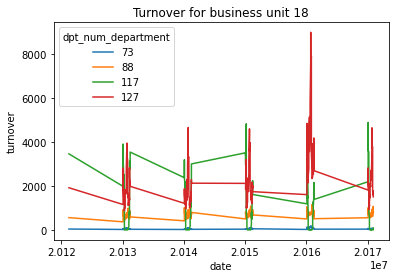

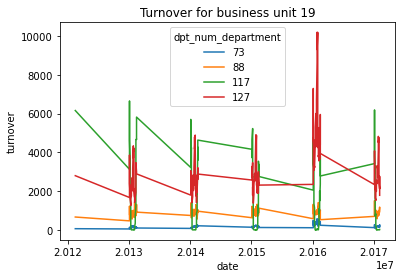

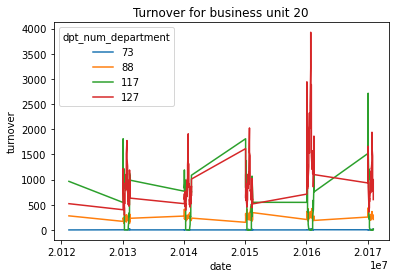

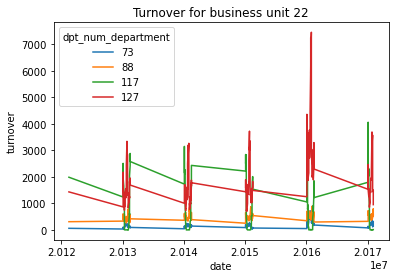

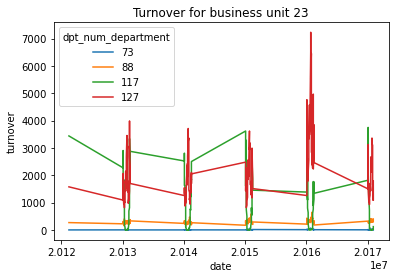

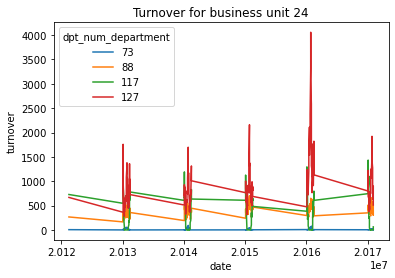

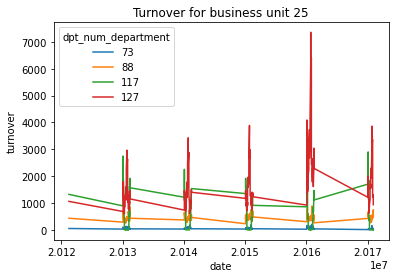

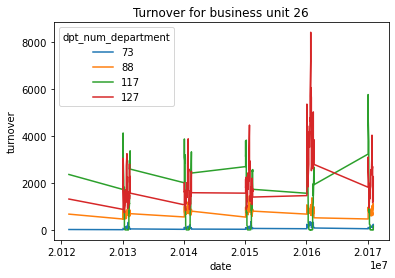

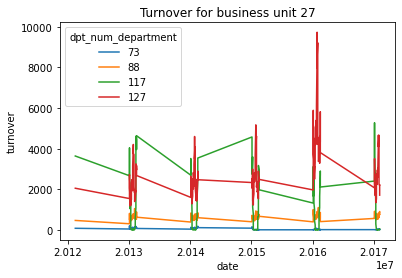

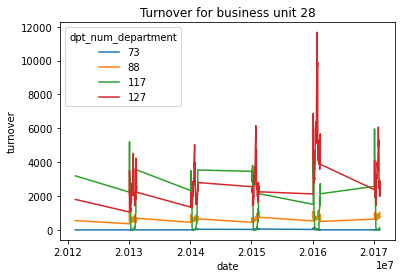

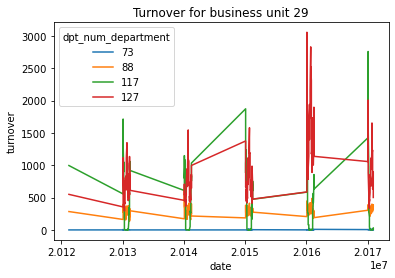

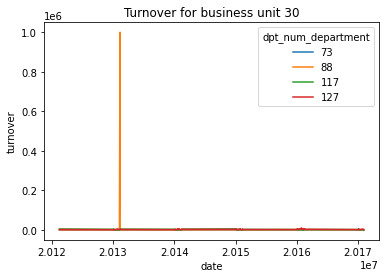

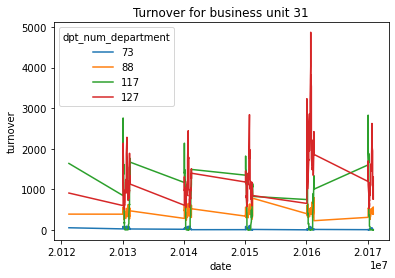

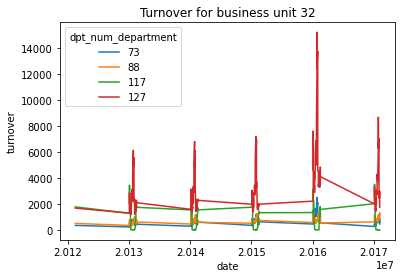

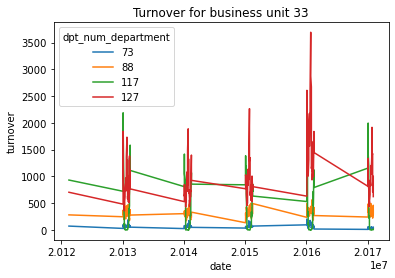

In [17]:
for i, bu in enumerate(list(df_plot["but_num_business_unit"].unique())):
    if i < 30:
        df_ventes_filt = df_plot[(df_plot["but_num_business_unit"]==bu)]
        #df_ventes_filt_grouped = df_ventes_filt.groupby(["dpt_num_department","but_num_business_unit","year","month"]).sum().reset_index()
        plt.figure(i)
        plt.title(f"Turnover for business unit {bu}")
        sns.lineplot(data=df_ventes_filt, x='date', y='turnover', hue='dpt_num_department',palette="tab10")

In [18]:
# from the graph above, we can conclude that all the departments follow a different pattern. 
# We should cannot group them immediately

In [19]:
#voir pour regrouper les sports ou les magasins si ils ont le même pattern

#representation des sports par magasin -> potentiellement faire forecast sur CA total 
#du magasin et on applique le pourcentage pour avoir le sport

#representation du CA du magasin dans la region -> au fil du temps, toujours la même part de CA dans le CA region
#-> potentiellement faire forecast CA total et appliquer le pourcentage pour avoir le magasin

In [20]:
#representation des sports par magasin

In [21]:
df_train_grouped.head(2)

,turnover,dpt_num_department,but_num_business_unit,year,month,week,date
0,15.552508,73,1,2012,12,52,20121252
1,8.092452,73,1,2013,01,00,20130100


In [22]:
df_tmp = df_train_grouped[["but_num_business_unit","dpt_num_department","turnover"]]
df_sport_magasin_year = df_tmp.groupby(["but_num_business_unit","dpt_num_department"]).sum()#.reset_index()

In [23]:
df_sport_magasin_year.head()

turnover
but_num_business_unit dpt_num_department               
1                     73                   10727.897559
                      88                   84318.204258
                      117                  75854.560702
                      127                 226964.061391
2                     73                   14738.507274

In [24]:
df_sport_magasin_year["percentage"] = df_sport_magasin_year.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2))

In [25]:
df_filt = df_sport_magasin_year.reset_index()

In [26]:
df_filt = df_filt[df_filt["percentage"].isnull()!=True]

/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


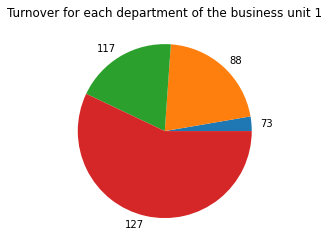

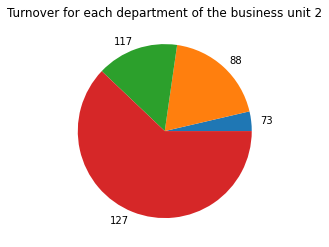

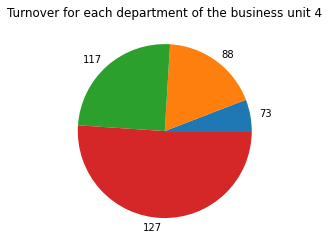

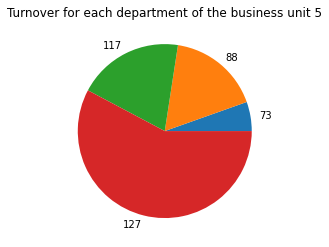

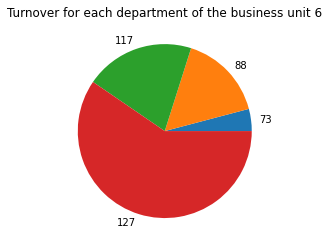

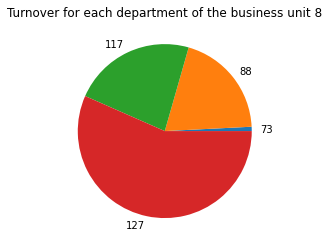

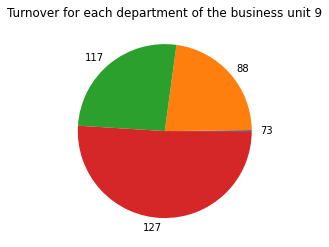

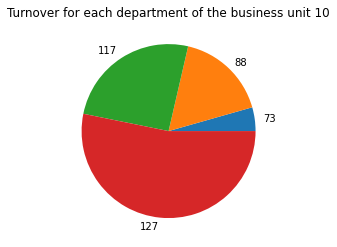

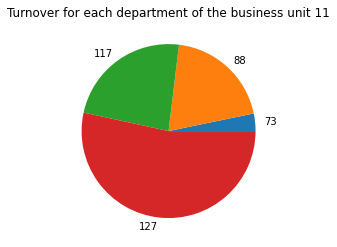

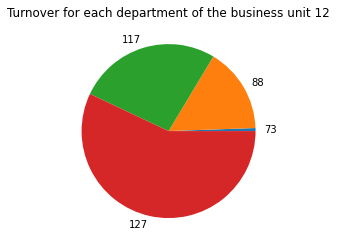

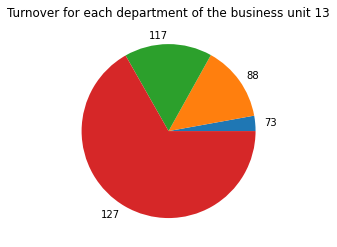

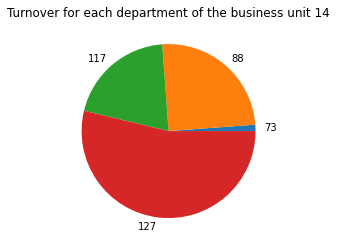

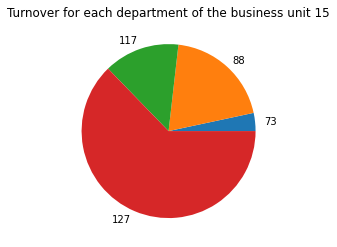

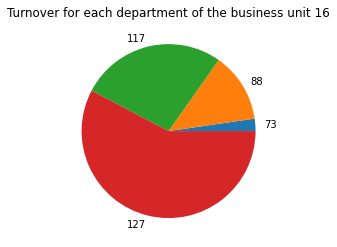

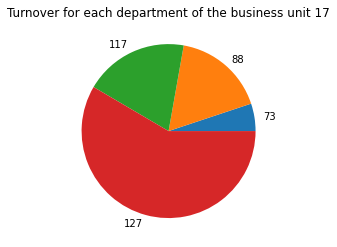

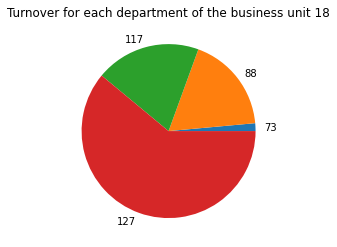

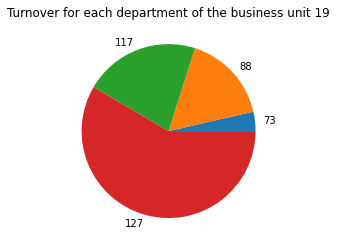

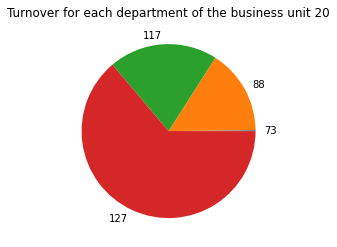

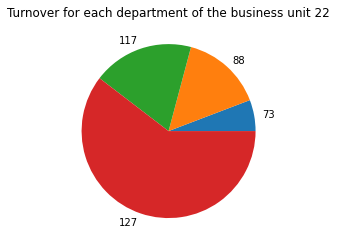

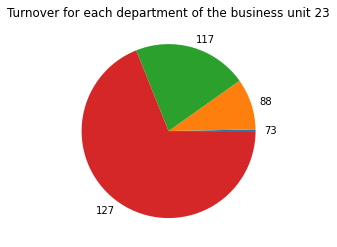

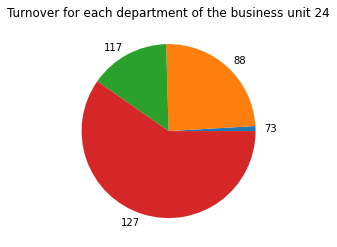

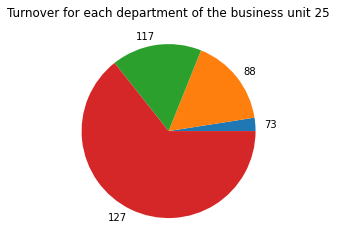

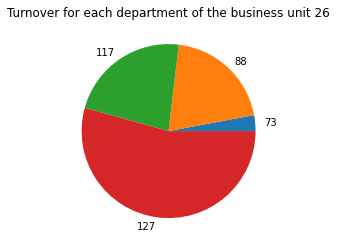

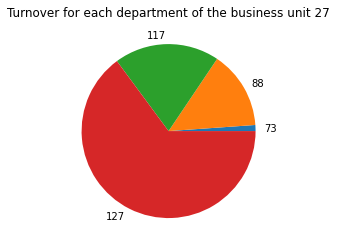

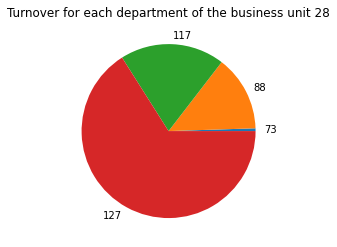

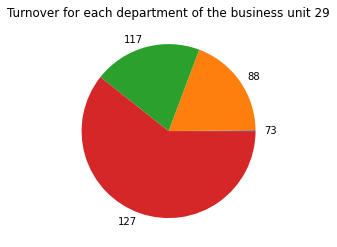

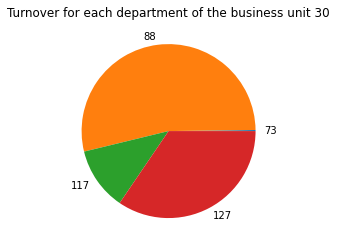

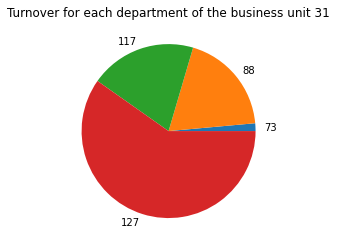

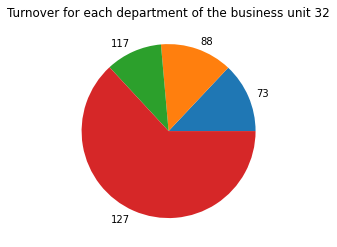

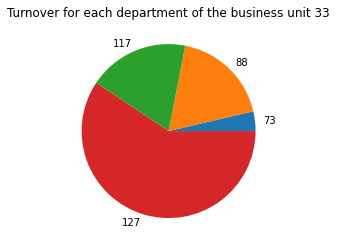

In [27]:
for i, bu in enumerate(list(df_filt["but_num_business_unit"].unique())):
    if i < 30:
        #year = 2017
        filt_bu = (df_filt["but_num_business_unit"]==bu)
        #filt_year = (df_sport_magasin_year["year"]==year)
        df_filt_plot = df_filt[filt_bu]
        #df_ventes_filt_grouped = df_ventes_filt.groupby(["dpt_num_department","but_num_business_unit","year","month"]).sum().reset_index()
        plt.figure(i)
        plt.title(f"Turnover for each department of the business unit {bu}")
        #sns.barplot(data=df_filt, x='dpt_num_department', y='turnover',palette="tab10")
        plt.pie(df_filt_plot['percentage'],labels=df_filt_plot['dpt_num_department'])

In [31]:
# from the plot above, we can conclude that for all the business unit, the sport representation of each 
# department in the yearly turnover of the business units is very similar.
# It means that the forecast of the global turnover can be made and then the percentage of representation of each 
# department will be applied.

In [32]:
# find the percentage of each department

In [34]:
df_filt.head(2)

,but_num_business_unit,dpt_num_department,turnover,percentage
0,1,73,10727.897559,2.70
1,1,88,84318.204258,21.19


In [36]:
for dep in list(df_filt["dpt_num_department"].unique()):
    filt_dep = df_filt["dpt_num_department"]==dep
    df_dep = df_filt[filt_dep]
    print(f'Department {dep} : percentage representation mean : {df_dep["percentage"].mean()}')

Department 73 : percentage representation mean : 3.7614873417721517
Department 88 : percentage representation mean : 17.27596875
Department 117 : percentage representation mean : 17.056952380952378
Department 127 : percentage representation mean : 62.807917981072556
